In [86]:
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import matplotlib.cm as mplcm
import matplotlib.colors as colors
import pandas as pd
import numpy as np
import os
import datetime as dt
from datetime import datetime,timedelta
import matplotlib.ticker as ticker
from matplotlib.ticker import LinearLocator

%matplotlib inline
mpl.rcParams["axes.labelsize"] = 24
mpl.rcParams["axes.titlesize"] = 24
mpl.rcParams["xtick.labelsize"] = 18
mpl.rcParams["ytick.labelsize"] = 22
mpl.rcParams["lines.linewidth"] = 2
mpl.rcParams["legend.fontsize"] = 17
mpl.rcParams["xtick.direction"] = "in"
mpl.rcParams["ytick.direction"] = "in"
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["image.cmap"] = "viridis"

ROOT_DIR = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))
RESULTS_DIR = os.path.join(ROOT_DIR, "results")
RESULTS_DIR_F = os.path.join(ROOT_DIR, "results_filtered")


In [87]:
def thresholding_algo(y, lag, threshold, influence):
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    for i in range(lag, len(y) - 1):
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter [i-1]:
            if y[i] > avgFilter[i-1]:
                signals[i] = 1
            else:
                signals[i] = -1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag):i])
            stdFilter[i] = np.std(filteredY[(i-lag):i])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag):i])
            stdFilter[i] = np.std(filteredY[(i-lag):i])

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))

   
def prepare_topics(df,lag,threshold):

    # padding empty columns, sorting columns
    for i in range(200):
        if f"Topic_{i}" not in df.columns:
            df[f"Topic_{i}"] = 0
    df = df[df.columns[df.columns.str[6:].astype(float).argsort()]]

    for i in range(200):
        arr = df.to_numpy()
        y = arr[:,i]

        result = thresholding_algo(y, lag, threshold, influence=0)
        avg_filter = result["avgFilter"]
        threshold_filter = result["avgFilter"] + threshold * result["stdFilter"]
        signals = result["signals"]
        
        for j in range(0,len(signals)):
            if signals[j] < 1:
                signals[j] = -5
            else:
                signals[j] = y[j]

        df[f"avg_filter_topic_{i}"] = avg_filter
        df[f"threshold_filter_topic_{i}"] = threshold_filter
        df[f"signals_topic_{i}"] = signals
        df[f"y_{i}"] = y

    return df

In [88]:
def multi_line_peaks_plot(df, title, threshold):
    topics = [col for col in df.columns if col.startswith("Topic_")]
    series = [df[topic] for topic in topics]
    fig, ax = plt.subplots(figsize=(25, 7))
    beginning, end = dt.date(2022, 1, 1), dt.date(2023,1,1)
    cm = plt.get_cmap('nipy_spectral')
    topic_count = len(series)
    cNorm  = colors.Normalize(vmin=0, vmax=topic_count-1)
    scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
    color_list = [scalarMap.to_rgba(i) for i in range(0,topic_count)]

    for data, color, topic in zip(series, color_list, topics):
        if max(data) >= threshold:
            ax.plot(data.index.values, data, color=color, lw=0.8, alpha=0.7, label=topic)
            
    ax.set(title=title, xbound=(beginning, end),ylim=(0))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b-%y"))
    ax.get_xaxis().set_tick_params(which='both', rotation=0)
    return fig


In [89]:
def filtered_multi_lines_peaks_plot(df, kwargs, limit):
    fig, ax = plt.subplots(figsize=(25, 7))
    beginning = dt.date(2022, 1, 1)
    end = dt.date(2023,1,1)
    title = "Filtered Topic Peaks"

    colors = {
        "red":[1, 15, 56, 61, 65, 68, 72, 107, 134, 159, 166, 177, 180, 181, 185, 114, 184],
        "blue":[0, 10, 21, 35, 39, 80, 110, 115, 122, 128, 153, 161, 163, 176],
        "magenta":[9, 16, 31, 44, 87, 95, 131, 152, 164, 169, 194],
        "green":[19, 30, 40, 49, 72, 81, 97, 117, 149],
        "grey":[2, 12, 41, 50, 51, 136, 153],
    }

    labels = {
        "red":"Advances, Battles, Attacks and Effects of War",
        "blue":"Politics",
        "magenta":"Prices, Supply Chain and Sanctions",
        "green":"Artillery and Troops",
        "grey":"Other",
    }

    uniques = []
    for i in kwargs["All"]:
        topic = i["topic"]
        lag = i["lag"]
        threshold = i["threshold"]
        topic_data = prepare_topics(df, lag, threshold)
        signals = topic_data[f"signals_topic_{topic}"]
        y = topic_data[f"y_{topic}"]
        color = None
        for i in colors.items():
            if topic in i[1]:
                color = i[0]
                label = labels[color]
                if color not in uniques:
                    uniques.append(color)
                else:
                    label = None
                break
        if max(signals) >= limit:
            ax.step(topic_data.index.values, signals, c=color, lw=0.8, alpha=1, label=label)

    ax.set(title=title, xbound=(beginning, end), ylim=(0))
    date_form = DateFormatter("%b-%y")
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(date_form)
    ax.legend(loc='upper right', bbox_to_anchor=(1, 1))
    L = ax.legend()
    plt.setp(L.texts, family='Arial') 
    L.get_frame().set_linewidth(0.0)
    plt.show()
    
    return fig


In [90]:
def category_plot(df, kwargs, limit, chosen_cat, lim):
    cats = {
        "bat":[1, 15, 56, 61, 65, 68, 72, 107, 134, 159, 166, 177, 180, 181, 185, 114, 184],
        "pol":[0, 10, 21, 35, 39, 80, 110, 115, 122, 128, 153, 161, 163, 176],
        "pri":[9, 16, 31, 44, 87, 95, 131, 152, 164, 169, 194],
        "art":[19, 30, 40, 49, 72, 81, 97, 117, 149],
        "oth":[2, 12, 41, 50, 51, 136, 153],
    }
    titles = {
        "bat":"Advances, Battles, Attacks and Effects of War",
        "pol":"Politics",
        "pri":"Prices, Supply Chain and Sanctions",
        "art":"Artillery and Troops",
        "oth":"Other",
    }
    
    cat_topics = cats.get(chosen_cat)
    if not cat_topics:
        return None

    fig, ax = plt.subplots(figsize=(25, 7))
    beginning = dt.date(2022, 1, 1)
    end = dt.date(2023,1,1)
    title = "Filtered Topic Peaks"

    for i in kwargs["All"]:
        topic = i["topic"]
        if topic not in cat_topics:
            continue
        lag = i["lag"]
        threshold = i["threshold"]
        topic_data = prepare_topics(df,lag,threshold)
        signals = topic_data[f"signals_topic_{topic}"]
        y = topic_data[f"y_{topic}"]

        if max(signals) >= limit:
            ax.step(topic_data.index.values, signals, lw=1, alpha=1,label=topic)

        for i in range(len(signals)):
            if signals[i] >= lim:
                ax.text(topic_data.index.values[i], signals[i], str(int(signals[i])), ha='center', va='bottom', fontsize=9)

    ax.set(title=f"{titles.get(chosen_cat)} - Peaks", xbound=(beginning, end), ylim=(0))

    date_form = DateFormatter("%b-%y")
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(date_form)
    start, end = ax.get_ylim()
    ax.legend(loc='upper right', bbox_to_anchor=(1, 1))
    L = ax.legend()
    plt.setp(L.texts, family='Arial') 
    L.get_frame().set_linewidth(0.0)
    ticks = [tick for tick in ax.xaxis.get_majorticklabels()]
    ticks[0].set_horizontalalignment("left")
    
    plt.show()
    
    return fig

In [91]:
kwargs = {
    "All":[
    {"topic":0,"lag":314,"threshold":7},
    {"topic":1,"lag":238,"threshold":15},
    {"topic":2,"lag":235,"threshold":9},
    {"topic":9,"lag":385,"threshold":5.5},
    {"topic":10,"lag":230,"threshold":5},
    {"topic":12,"lag":300,"threshold":7},
    {"topic":15,"lag":413,"threshold":14},
    {"topic":16,"lag":235,"threshold":7},
    {"topic":19,"lag":330,"threshold":5},
    {"topic":21,"lag":350,"threshold":7},
    {"topic":30,"lag":265,"threshold":5},
    {"topic":31,"lag":450,"threshold":7},
    {"topic":35,"lag":340,"threshold":6},
    {"topic":39,"lag":200,"threshold":2},
    {"topic":40,"lag":285,"threshold":8},
    {"topic":41,"lag":240,"threshold":8},
    {"topic":44,"lag":240,"threshold":8},
    {"topic":49,"lag":390,"threshold":8},
    {"topic":50,"lag":240,"threshold":15},
    {"topic":51,"lag":460,"threshold":8},
    {"topic":56,"lag":270,"threshold":13},
    {"topic":61,"lag":240,"threshold":3},
    {"topic":65,"lag":240,"threshold":6},
    {"topic":68,"lag":355,"threshold":6},
    {"topic":72,"lag":430,"threshold":6},
    {"topic":80,"lag":235,"threshold":15},
    {"topic":81,"lag":240,"threshold":9},
    {"topic":87,"lag":260,"threshold":6},
    {"topic":95,"lag":240,"threshold":7},
    {"topic":97,"lag":464,"threshold":16},
    {"topic":107,"lag":460,"threshold":7},
    {"topic":110,"lag":235,"threshold":6},
    {"topic":114,"lag":248,"threshold":7},
    {"topic":115,"lag":235,"threshold":7},
    {"topic":117,"lag":443,"threshold":9},
    {"topic":122,"lag":265,"threshold":6},
    {"topic":128,"lag":235,"threshold":15},
    {"topic":131,"lag":240,"threshold":13},
    {"topic":134,"lag":240,"threshold":5},
    {"topic":136,"lag":425,"threshold":5},
    {"topic":149,"lag":250,"threshold":25},
    {"topic":152,"lag":240,"threshold":12},
    {"topic":153,"lag":500,"threshold":8},
    {"topic":159,"lag":278,"threshold":7},
    {"topic":161,"lag":265,"threshold":6},
    {"topic":163,"lag":250,"threshold":7},
    {"topic":164,"lag":248,"threshold":10},
    {"topic":166,"lag":518,"threshold":5},
    {"topic":169,"lag":237,"threshold":5},
    {"topic":176,"lag":238,"threshold":5.5},
    {"topic":177,"lag":292,"threshold":5},
    {"topic":180,"lag":237,"threshold":15},
    {"topic":181,"lag":245,"threshold":9},
    {"topic":184,"lag":239,"threshold":5},
    {"topic":185,"lag":500,"threshold":23},
    {"topic":194,"lag":245,"threshold":9},
    ]
}


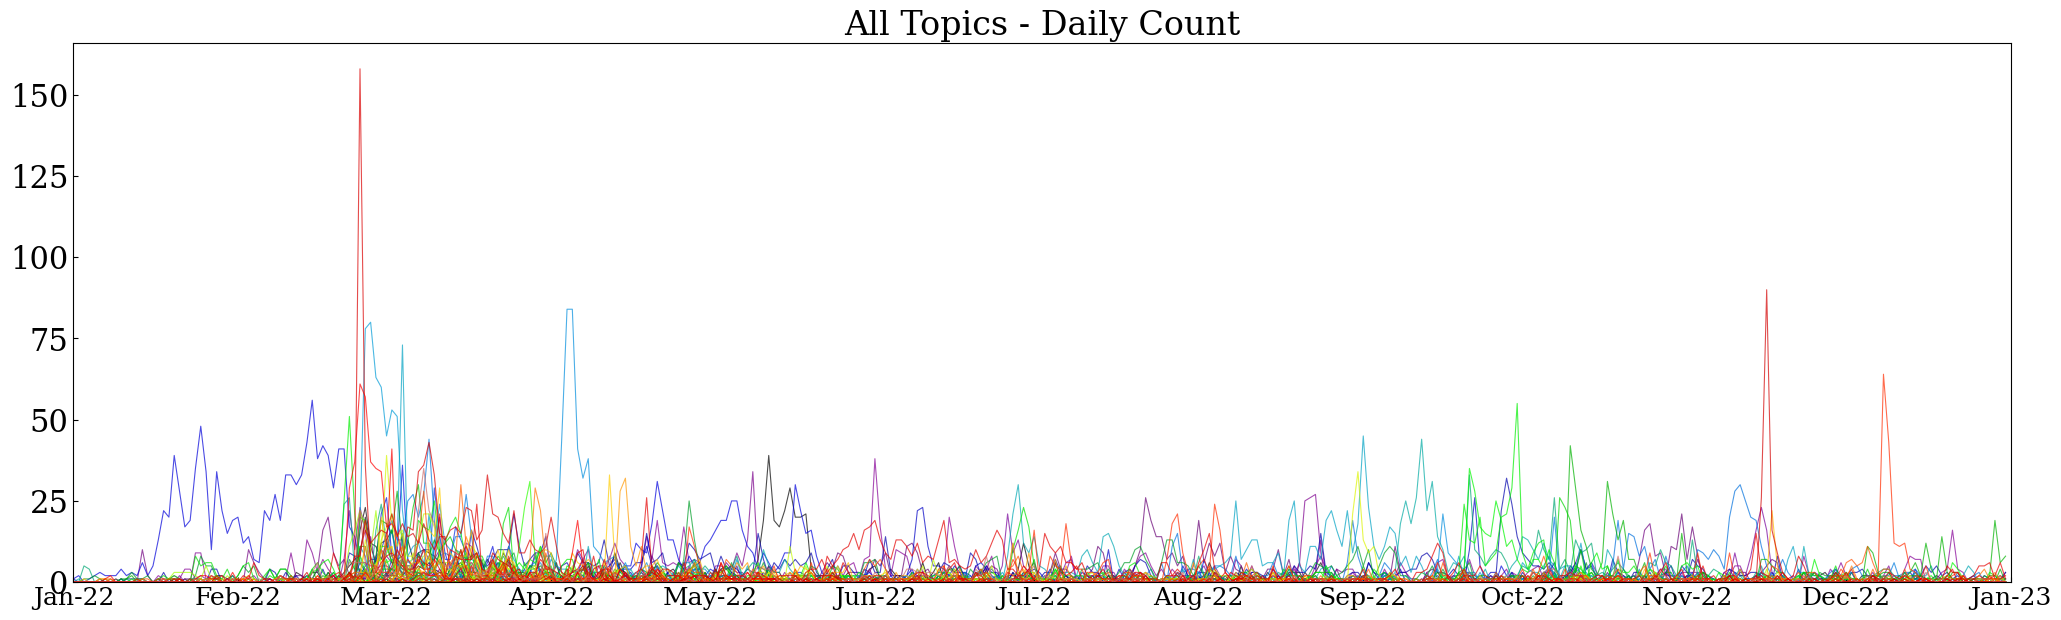

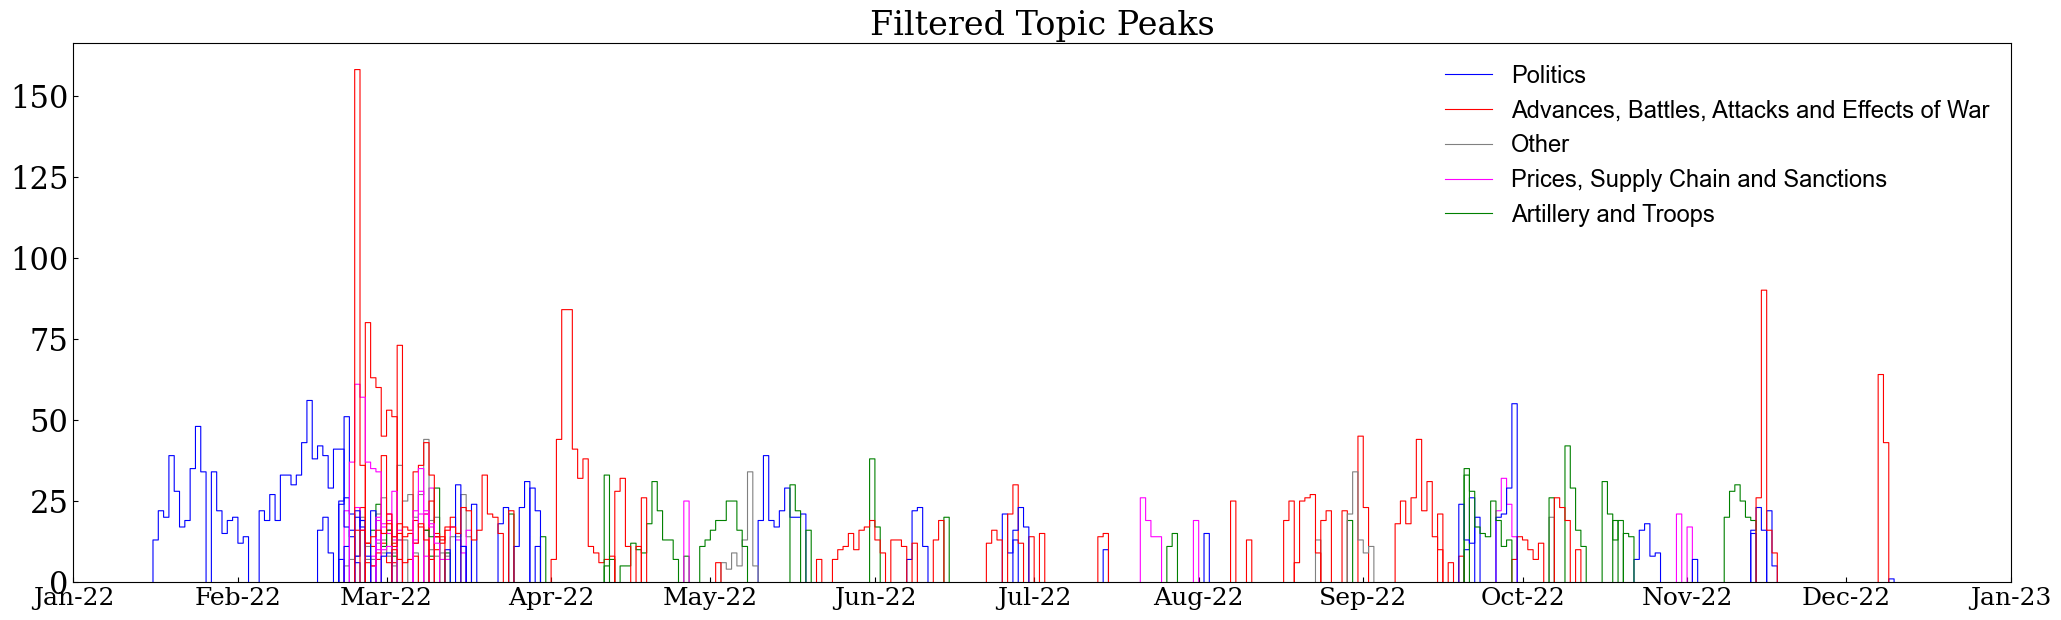

In [92]:
data_df = pd.read_csv(os.path.join(ROOT_DIR, "results_05", "All_Results.csv"), parse_dates=["Date"], index_col=["Date"])
data_df = pd.get_dummies(data_df.filter(["Topic"]), columns=['Topic'])
data_df = data_df.resample("D").sum()

fig = multi_line_peaks_plot(data_df, f"All Topics - Daily Count", threshold=20)
# fig.savefig(os.path.join(ROOT_DIR, "figures","topic_counts", f"Full_topic_count.svg"), format="svg", dpi=1000, bbox_inches="tight")

fig2 = filtered_multi_lines_peaks_plot(data_df,kwargs,0)
# fig2.savefig(os.path.join(ROOT_DIR, "figures","topic_counts", f"Filtered_topic_count.svg"), format="svg", dpi=1000, bbox_inches="tight")

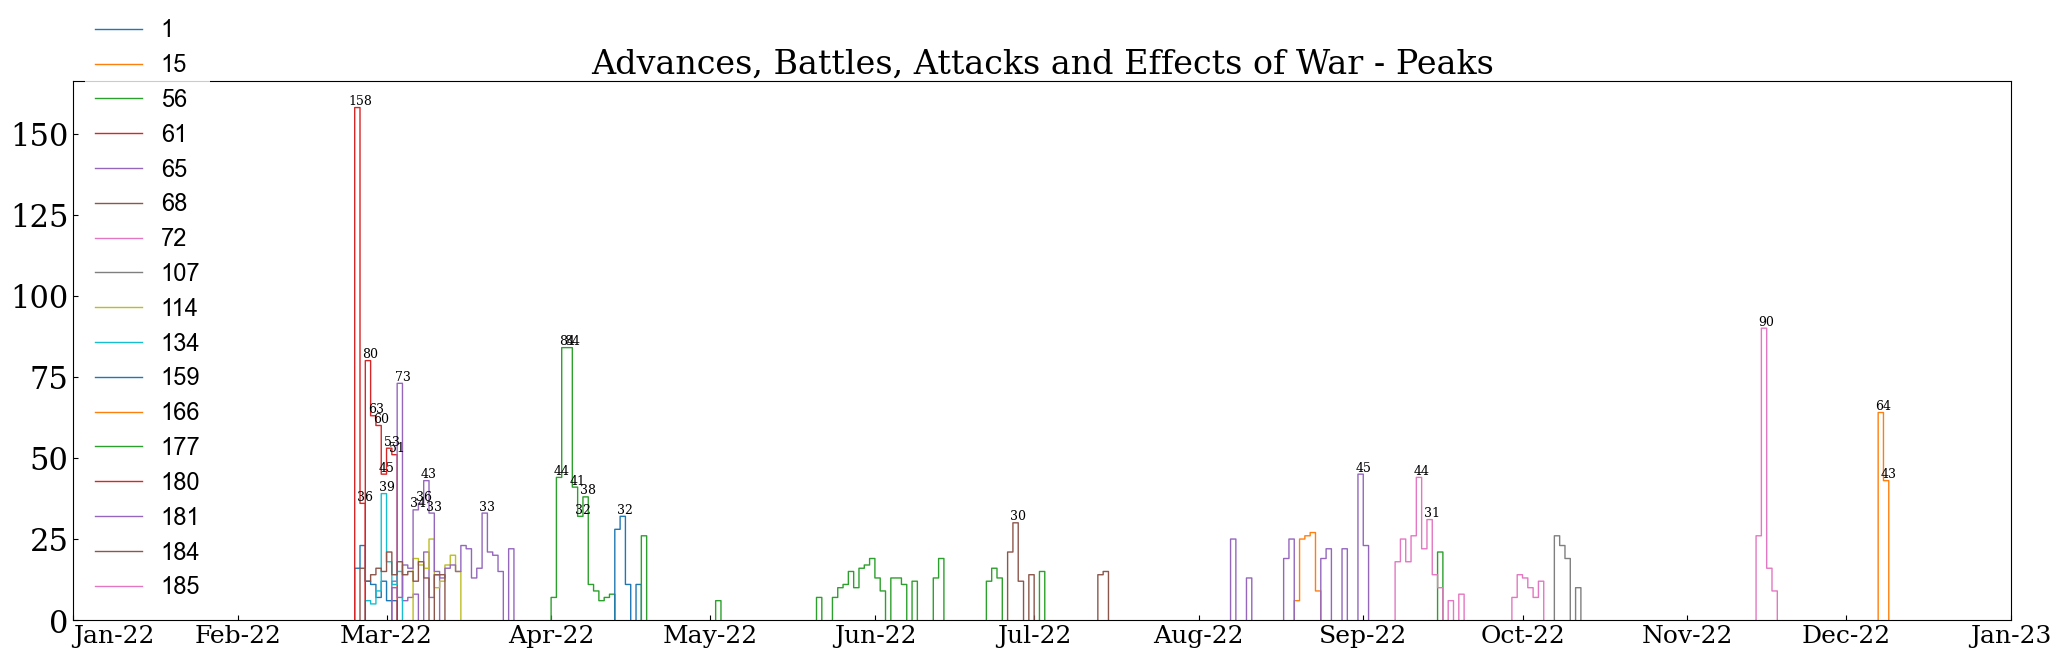

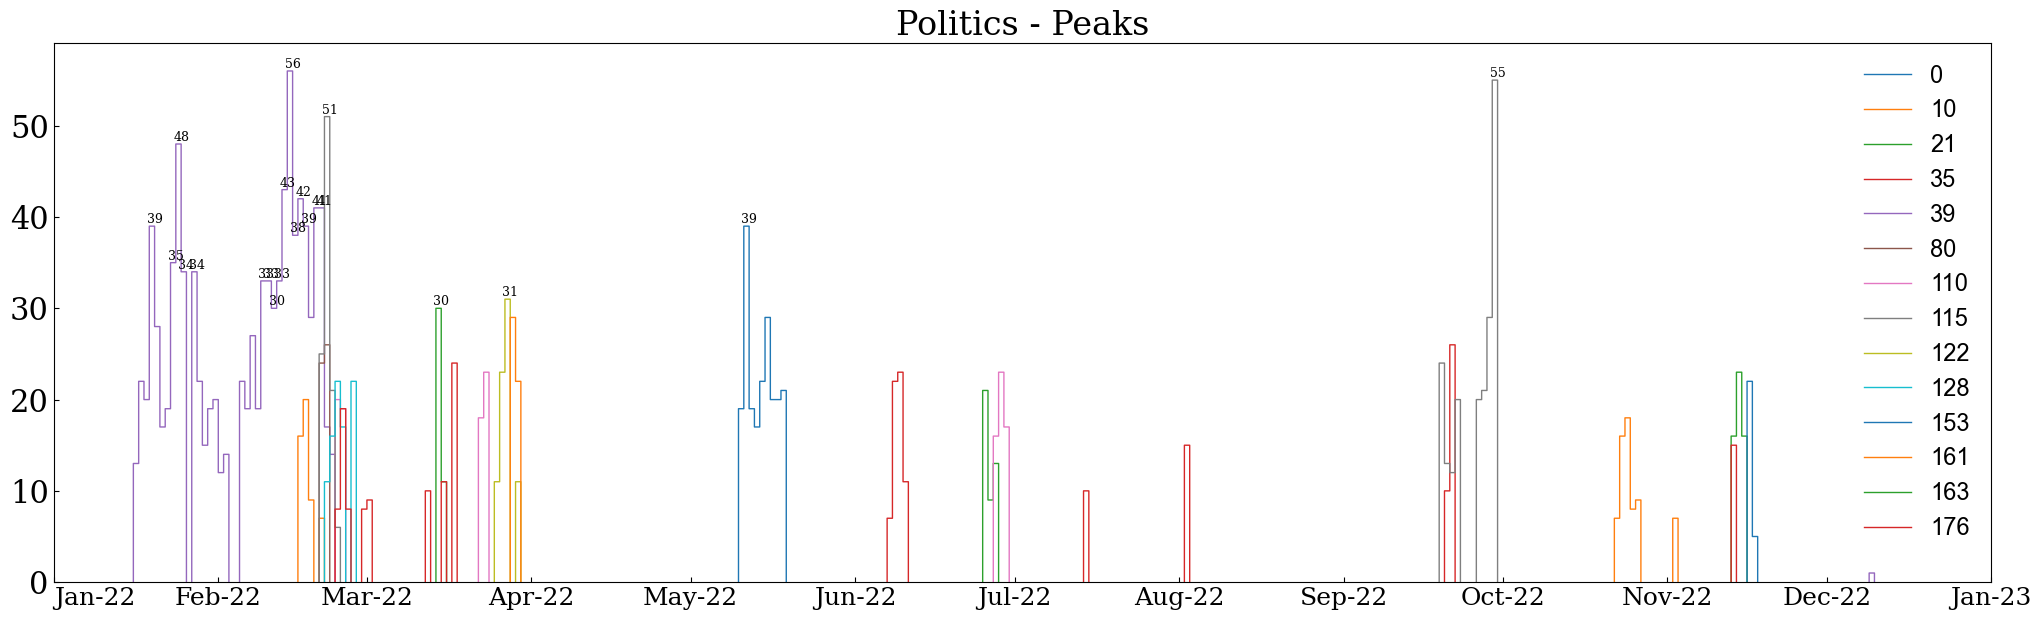

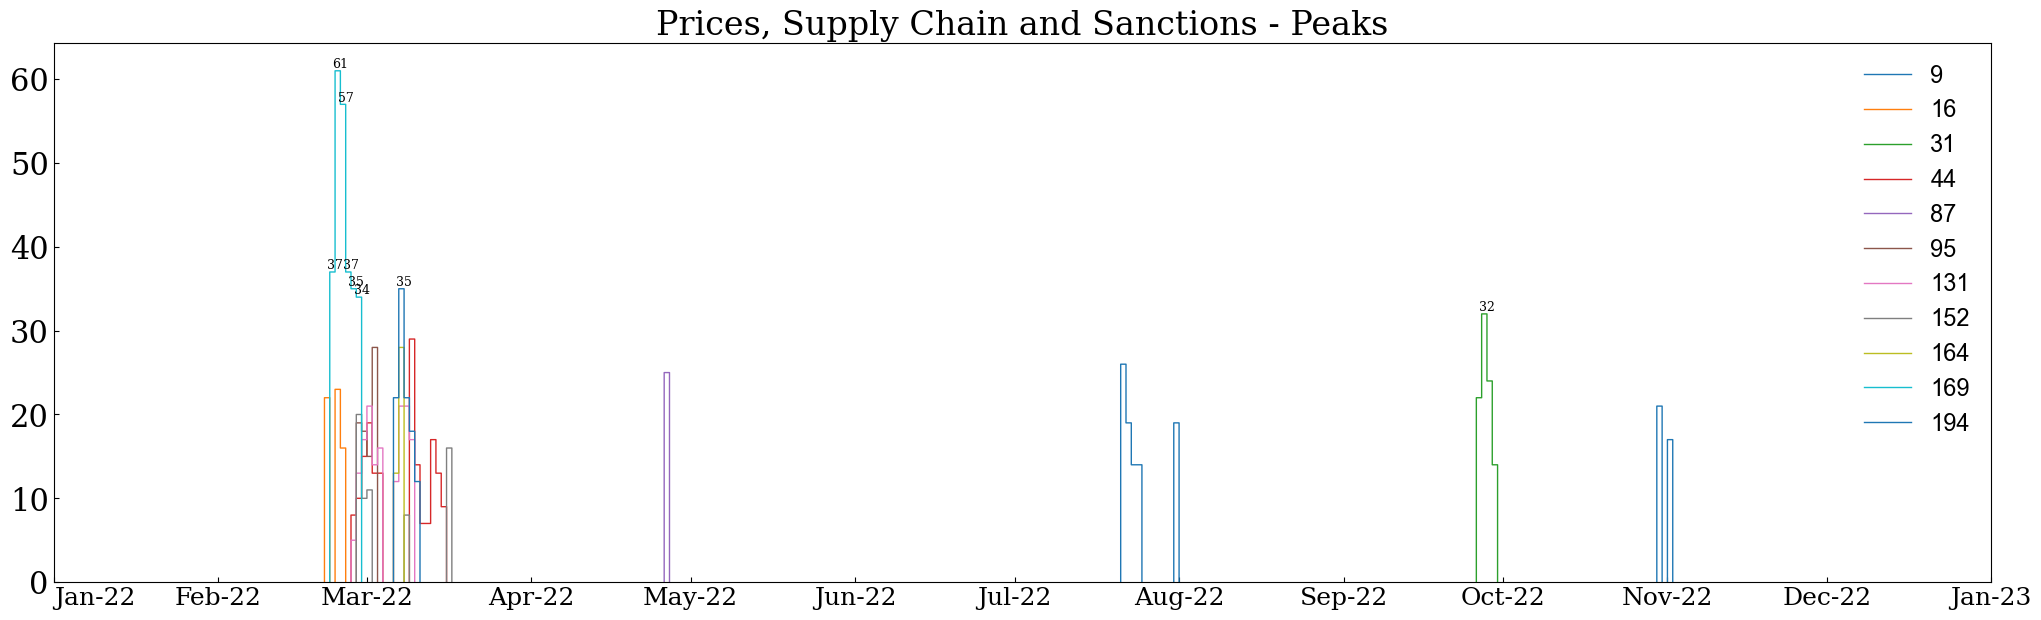

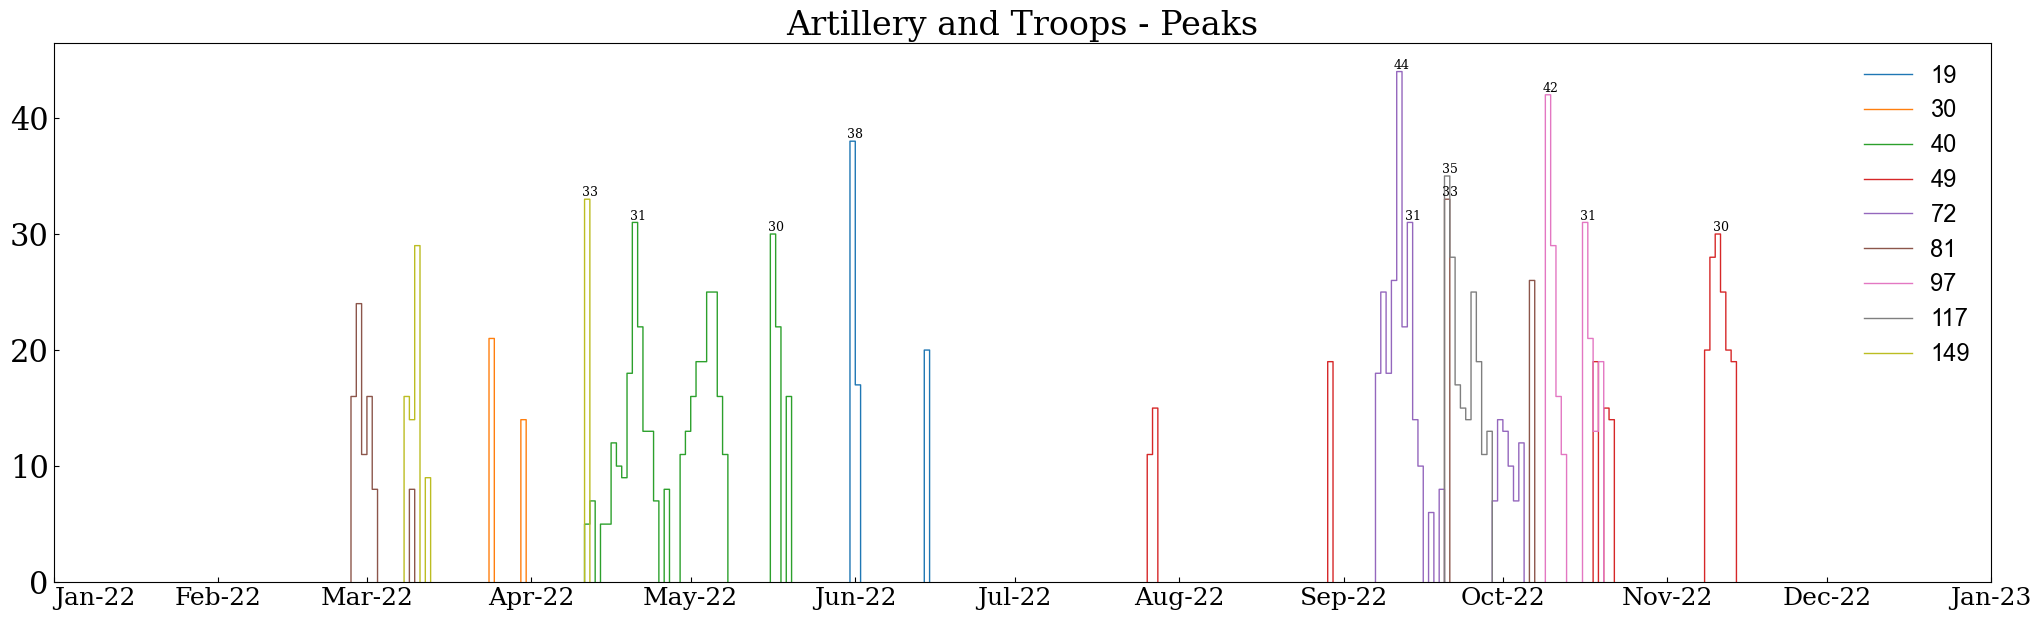

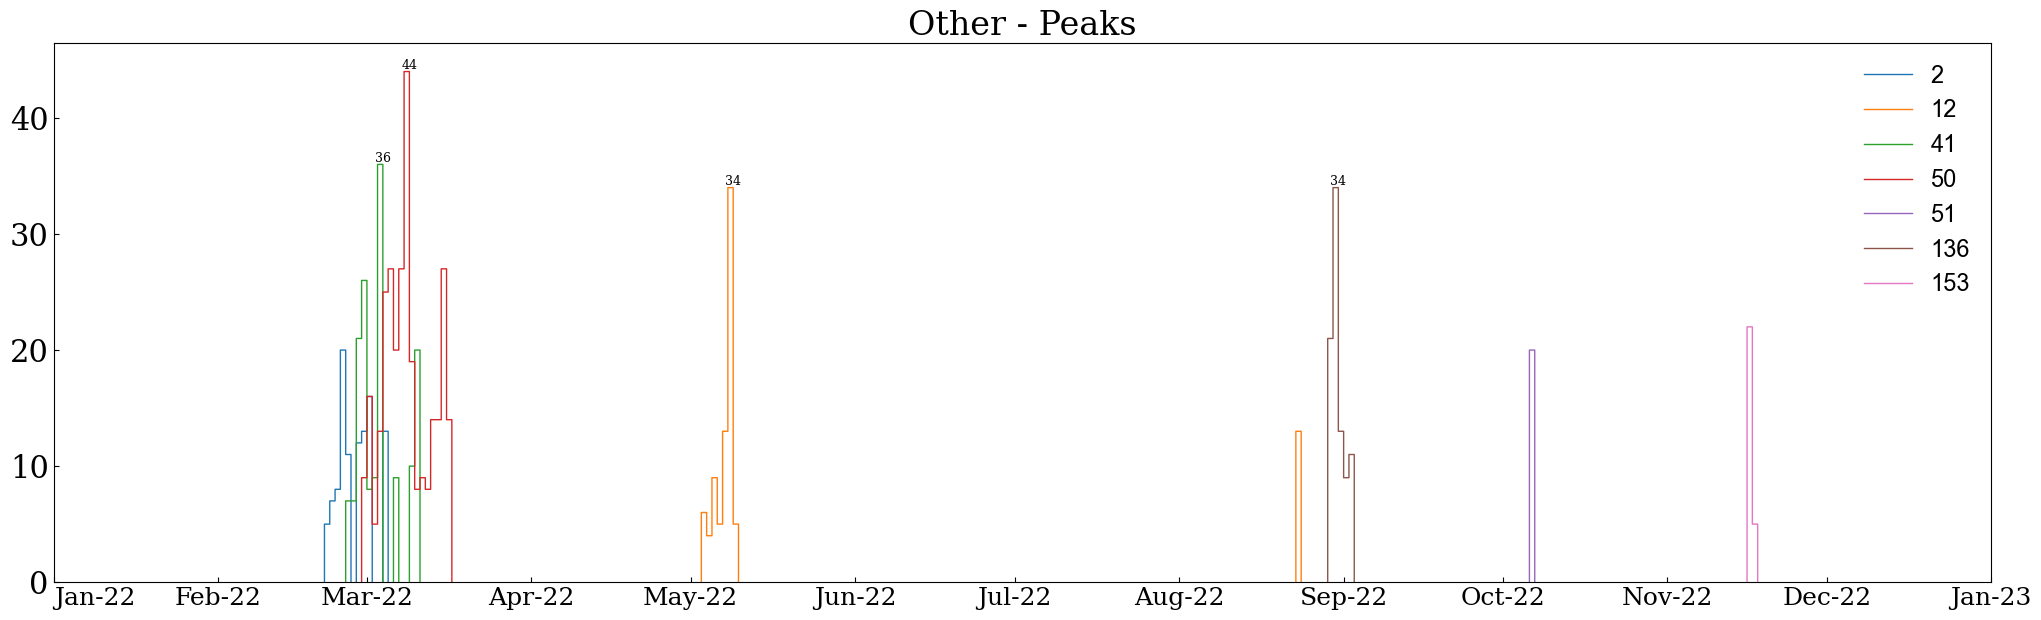

In [85]:
for f in ['bat','pol','pri','art','oth']:
    fig3 = category_plot(data_df,kwargs,0,f,lim=30)
